# Barbara simulation notebook

- Generate plots/test statistics for power analysis for Barbara
- Modified notebook from Hamish MacGregor
- supplementary figure 3 and supplementary figure 8

In [591]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.integrate as it
from scipy.stats import kde
import pandas as pd
from scipy.special import gamma
from IPython.display import clear_output
import scipy.optimize as opt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm
import os
import datetime
import matplotlib
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MaxNLocator
from scipy.stats import ks_2samp
from scipy.stats import fisher_exact
import time 
matplotlib.rc_file_defaults()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Helvetica'
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import random
from scipy.interpolate import interp1d

In [592]:
# SET UP

# specify font for plotting 
plt.rcParams.update({'font.sans-serif':'Helvetica'})
# this is to make things editable in Illustrator
plt.rcParams['pdf.fonttype'] = 42 
# stop printing warnings 
import warnings
warnings.filterwarnings("ignore")
# get current date 
timestr = time.strftime("%Y%m%d") 

# COLORS 
# colors for relative binding 
col0r = '#0AAE37' # this is used to plot the top group (highest score = most immunogenic / strongest binding) (orange is binding?)
col1r = '#8FE8A7' # this is used to plot the middle group 
col2r = '#B018ED' # this is used to plot the bottom group (turquoise = does not bind)

# colors for absolute binding (I think we decided we want to do the same colors for the moment)
col0a = '#0AAE37' # this is used to plot the top group (strong binding based on threshold) 
col1a = '#8FE8A7' # this is used to plot the middle group (weak binding based on threshold)
col2a = '#B018ED' # this is used to plot the bottom group (no binding based on threshold)

# for CH specifically for absolute binding I am just using slightly darker colors but overall not changing it much
col0a1 = '#001707' # this is used to plot the top group (strong binding based on threshold) for CH-neg in SF2 
col1a1 = '#037724' # this is used to plot the middle group (weak binding based on threshold) for CH-neg in SF2 
col2a1 = '#580479' # this is used to plot the bottom group (no binding based on threshold) for CH-neg in SF2 

# colors for CH-positive / CH-negative 
col_pos = '#BB0733' # color for CH-positive individuals (~reddish)
col_neg = '#6892ED' # color for CH-negative individuals (blue)
col_neg2 = '#8AAAEF' # lighter color for background (dots)

# light grey for background (alternating variants)
col_background = '#EEEEEE'

# FONTS
title_font = 14
xaxis_font = 12
yaxis_font = 12
xticks_font = 9
yticks_font = 9
legend_title = 12
legend_font = 11
text_font = 9

# Variant-agnostic, different values of s

In [593]:
# Import simulation 

# NOTE:
# true_freq is the true frequency of the clone
# freq2:
# var_reads2 comes from binomial sampling given n = 70 reads (median depth) with prob = p (true frequency)
# freq2 is just var_reads2 / total depth (ie 70 reads)
# given you filter based on reads not VAF perhaps better to filter via reads

# create empty dictionaries for each mu to store values in  
variants_dict = {}
variants_dict_filt = {}

# create empty lists to read s and mu 
fitness_coeff = []
mu_coeff = []

import os 

# path to the directory with folders with simulation results 
directory = r"/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_simulations_s_mu/" 
 
# Iterate over folders in the directory
for name in os.listdir(directory):
    
    # directory with the file to read
    directory_file = r"/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_simulations_s_mu/" + name
    
    if directory_file.split('_')[-1] != "Store": # skip hidden files 
        
        for name_file in os.listdir(directory_file):
            
            # Open file
            with open(os.path.join(directory_file, name_file)) as file:

                name = directory_file.split('/')[-1]
                
                if name_file.split('.')[-1] == 'csv': # only read csv files 
                    
                    # get the fitness coefficient
                    s = float(name.split('_')[1])
                    
                    fitness_coeff.append(s)

                    # get mutation rate 
                    mu = name.split('_')[2]
                    mu_coeff.append(mu)

                    if mu == '5e-7': 
                        # I ran the simulation for different values of mu
                        # we need a value high enough so you get enough cases from one simulation
                        # so only read if mu is 5e-7

                        # save the dataframe such that we know both the mu and the s
                        sim = pd.read_csv(file)
                        variants_bind = sim[['person_ID', 'freq2', 'var_reads2']]
                        variants_dict[s] = variants_bind
                        
                        sim_filt = sim[sim.var_reads2 >= 2].reset_index(drop=True) # only want to look at people who have CH (>= 2 reads out of 70)
                        variants_bind = sim_filt[['person_ID', 'freq2', 'var_reads2']] # get the Person ID, frequency (VAF) and nr reads (nr of reads set to 70)
                        variants_dict_filt[s] = variants_bind


# KS test (clone size distribution)

In [595]:
import copy

def modify_list(ls):
    
    new_ls = copy.deepcopy(ls)
    # don't want to modify the original list

    for sublist in new_ls:
        if sum(sublist) == len(sublist): # if there are no zeroes:
            idx = 0

        else:
            # find index of the last zero:
            idx = len(sublist) - 1 - sublist[::-1].index(0)

        # replace all ones before this with 0
        for i in range(0, idx):
            if sublist[i] == 1:
                sublist[i] = 0

    for i in range(1, len(new_ls)):
        if sum(new_ls[i]) > sum(new_ls[i-1]):
            new_ls[i] = new_ls[i-1]

    return new_ls


In [596]:
def find_boundaries(grid):
    
    boundaries = []

    # Check vertical boundaries within each row
    for y, row in enumerate(grid):
        try:
            # find the first 1 (this is the x coordinate)
            x = row.index(1)
            boundaries.append((x, y))
        except ValueError:
            # skip if only zeros 
            continue
    
    # add boundaries to mark horizontal transitions
    x_coords = [b[0] for b in boundaries]
    y_coords = [b[1] for b in boundaries]
    all_x = set(range(min(x_coords), len(grid[0]))) # all x coords you want
    present_x = set(x_coords) # for whcih x coords you have data points already
    missing_x = sorted(list(all_x - present_x))

    new_coords = []

    for x in missing_x:
        possible_y = [y for x_next, y in boundaries if x_next >= x]
        if len(possible_y) == 0:
            new_y = max(y_coords)
        else:   
            new_y = min(possible_y)
        new_coords.append((x, new_y))
    
    # Add the new coordinates to the original list
    boundaries.extend(new_coords)
    # Sort coordinates by x-value
    boundaries.sort()

    return boundaries


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know

ValueError: min() arg is an empty sequence

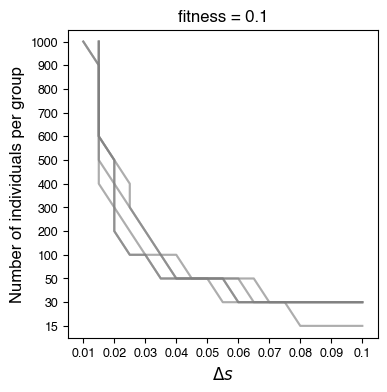

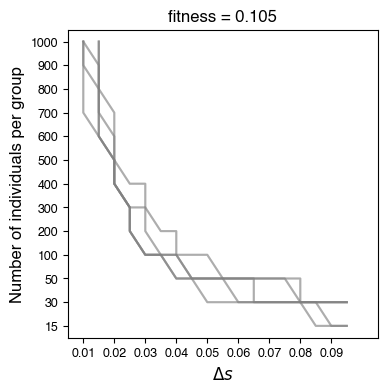

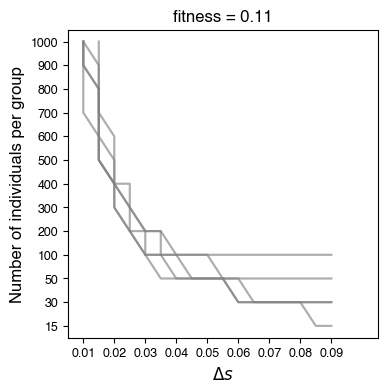

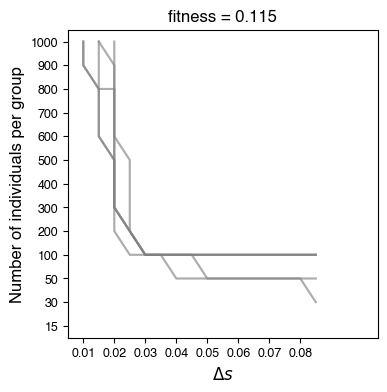

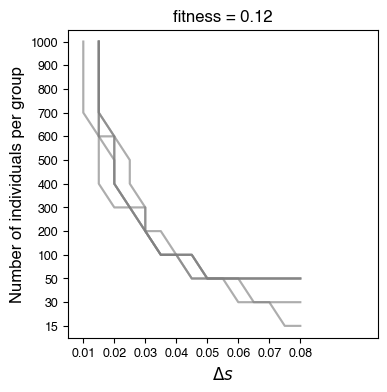

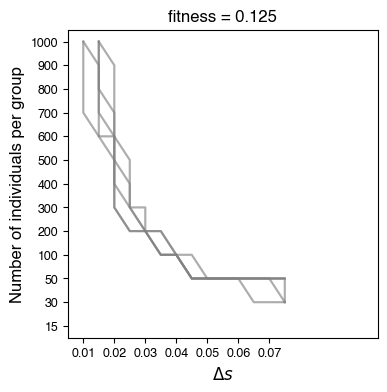

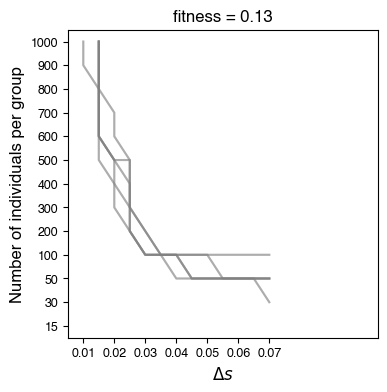

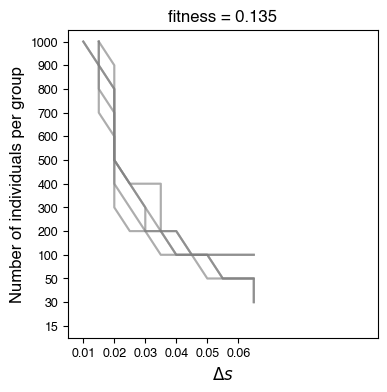

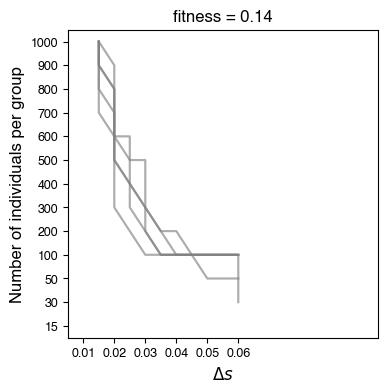

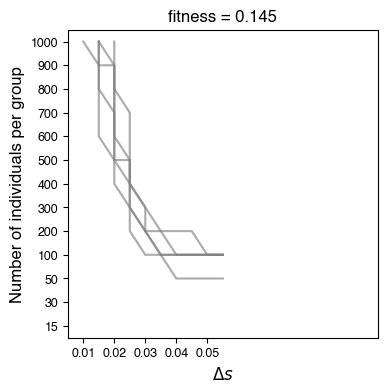

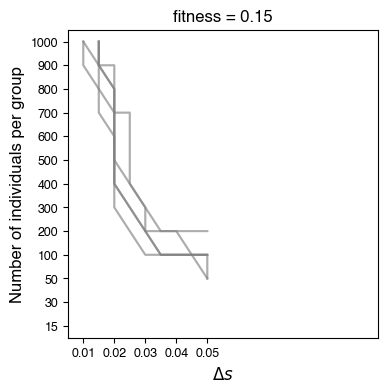

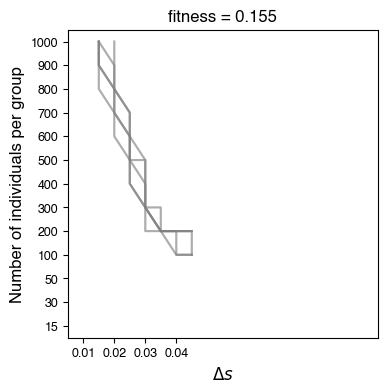

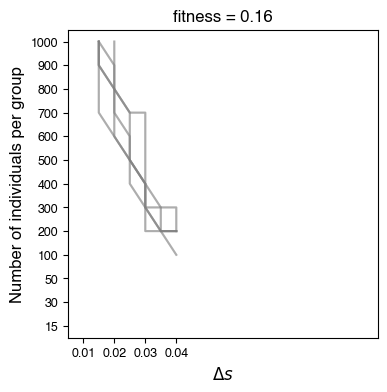

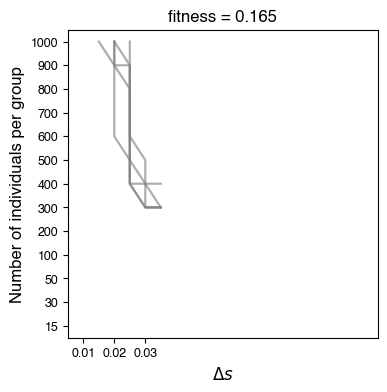

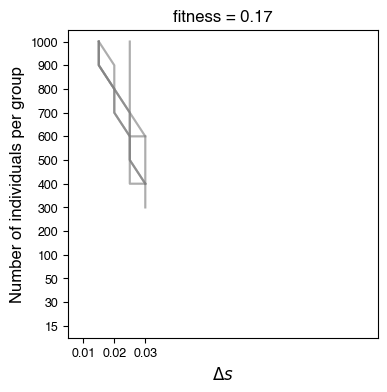

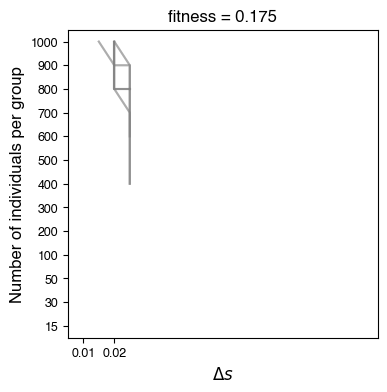

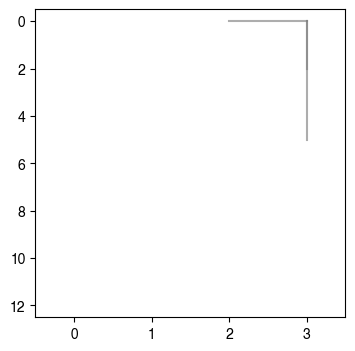

In [601]:

# try to get a plot of this now 
# okay let's try to plot this now accoording to what Jamie was suggesting
# you choose a specific s (say 0.1 for now)
# you want to plot the values for all other s (delta s is the difference)
# you want to then do this for different n 

# we want to go a bit less rough because it is noisy so just 0.1, 0.105, 0.11, 0.115 etc
s_values = np.arange(0.1, 0.201, 0.005).tolist()
s_values = [round(s, 4) for s in s_values]

n_values = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 30, 15] # nr of individuals to sample from each group 
n_labels = [900, 800, 700, 600, 500, 400, 300, 200, 100] # labels to include on the plot 
nx = len(n_values)

ks_values = {} # I also want to save the results as a csv so will write them to a dictionary

for s in s_values:
    
    # get delta s (difference b/n fitness coefficients)
    deltas = [sv - s for sv in s_values if s < sv]
    deltas = [round(d, 4) for d in deltas]

    ks_values[s] = {} # empty dictionary
    
    ks_lists = []
    ks_thresh = []
    
    for a in range(5):

        for n in n_values:

            ks_values[s][n] = {}
            ks_list = []

            random.seed(a)
            
            for d in deltas:

                # set seed
                
                # get values for different ns for the delta s 
                f1 = s # first s 
                f2 = round(s+d, 4) # second s (can do + or - doesn't matter)
                
                # extract dataframes with the same mu and different fitness values 
                # here I am only compared people "diagnosed with CH" - 2 reads     
                df1 = pd.DataFrame(variants_dict_filt[f1])
                df2 = pd.DataFrame(variants_dict_filt[f2])
                df1['s'] = f1
                df2['s'] = f2
                vaf1 = df1['freq2'].tolist()
                vaf2 = df2['freq2'].tolist()
            
                vaf1_sample = random.sample(vaf2, n)
                vaf2_sample = random.sample(vaf1, n)

                stat, ks = ks_2samp(vaf1_sample, vaf2_sample, alternative = 'less') 
                ks = min(1, ks.round(4) * 40)

                # save these values as a list
                ks_list.append(ks)    
                # add to the dictionary 
                ks_values[s][n][d] = ks 
        
            ks_lists.append(ks_list)
        
        # create a binary matrix 
        ks_new = [[1 if val < 0.01 else 0 for val in row] for row in ks_lists]

        # remove noise (highlight inner)   
        ks2 = []
        
        for i in range(5):
            ks_sub = ks_new[i*nx:(i+1)*nx]
            ks2_sub = modify_list(ks_sub) # this to be used for plotting (dot plot)
            ks2.append(ks2_sub)

        ks2_flat = [item for sublist in ks2 for item in sublist]

    # RESULTS 

    # PLOT
    
    boundaries = [0, 0.1, 1]  
    colors = ['white', 'white']  # just white background
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)

    plt.figure(figsize = (4, 4))
    plt.imshow(ks_new[0:nx], cmap = cmap, aspect = 'auto', norm = norm, interpolation='none')
    
    # plot boundary coordinates
    for i in range(5):
        ks_bound = ks2_flat[i*nx : (i+1)*nx]
        boundary_coords = find_boundaries(ks_bound)
        x_coords = [b[0] for b in boundary_coords]
        y_coords = [b[1] for b in boundary_coords]
        plt.plot(x_coords, y_coords, color = 'grey', linestyle = '-', alpha = 0.4)
        plt.plot(x_coords, y_coords, color = 'grey', linestyle = '-', alpha = 0.4)

    # plot formatting     
    plt.yticks(ticks=np.arange(nx), labels=[n_values[i] for i in range(nx)], fontsize = yticks_font)
    x_ticks = np.arange(1, len(deltas), 2)
    x_labels = [deltas[i] for i in x_ticks]
    plt.xticks(ticks=x_ticks, labels=x_labels, fontsize = xticks_font)
    plt.ylabel('Number of individuals per group', fontsize = yaxis_font)
    plt.xlabel(r'$\Delta s$', fontsize = xaxis_font)
    plt.xlim(0, 20)
    plt.title(label = f'fitness = {s}')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_figures/plot_ks_sn_s{s}.pdf', bbox_inches='tight')

    # TABLE WITH TEST VALUES 

    # save the ks values table to csv
    ks_table = pd.DataFrame(ks_values[s]) # that is actually the format that works anyway 
    ks_table.to_csv(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_stat_tables/ks_test_s{s}_5e7.csv')


# Fisher's exact test - main analysis

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know

ValueError: min() arg is an empty sequence

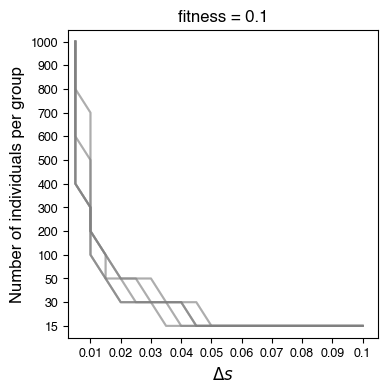

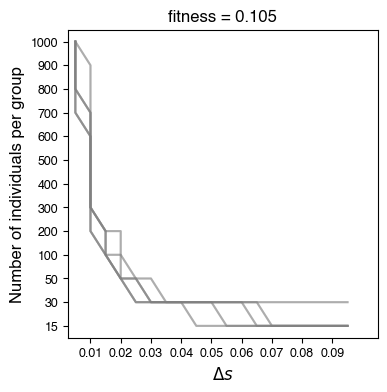

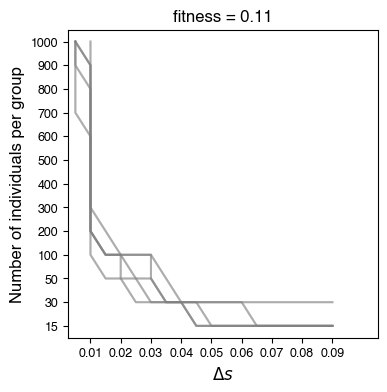

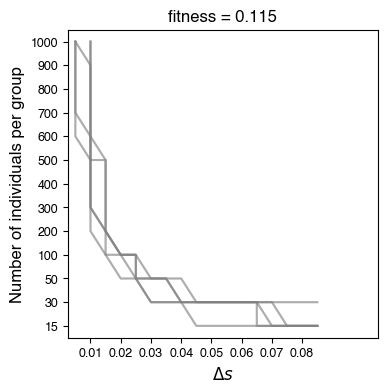

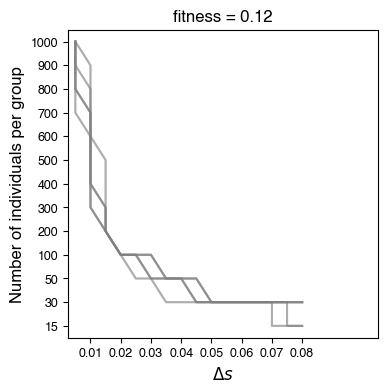

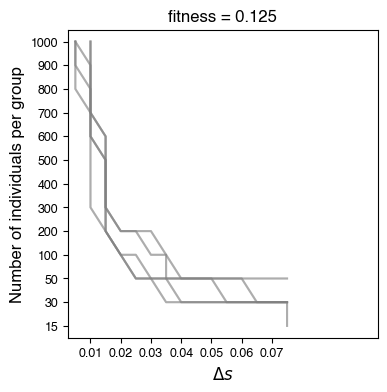

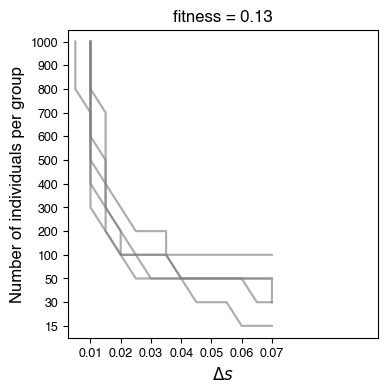

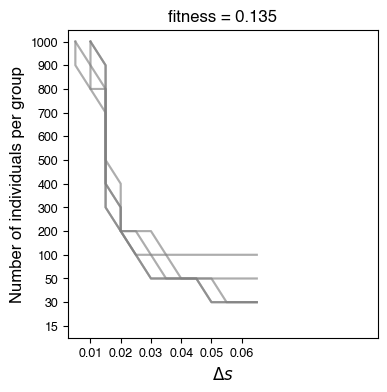

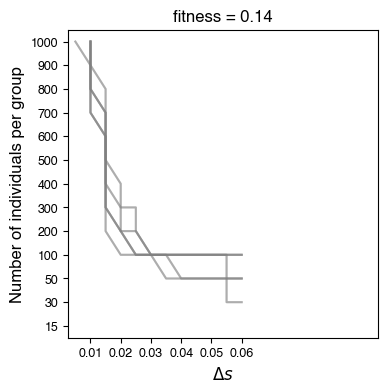

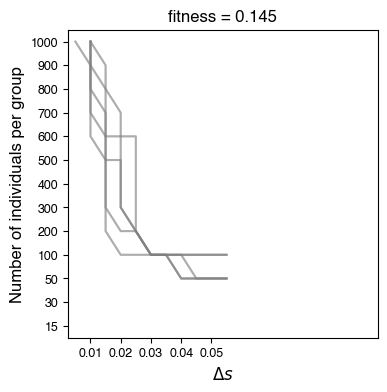

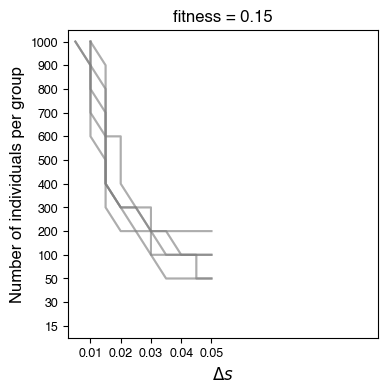

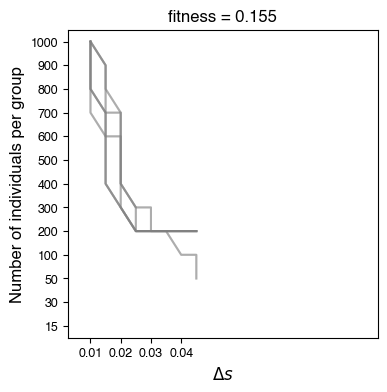

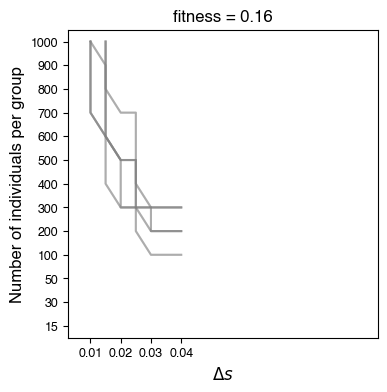

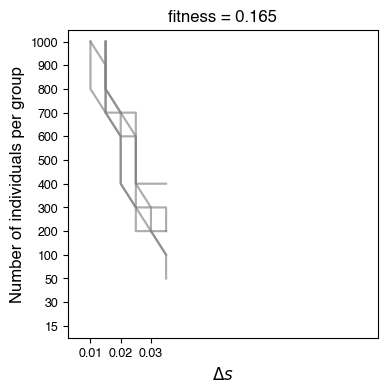

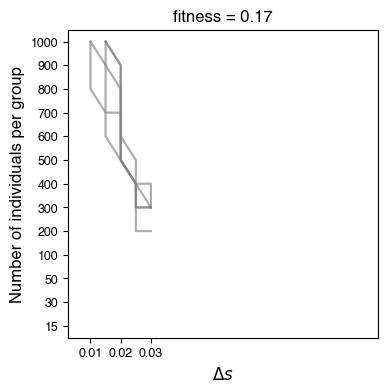

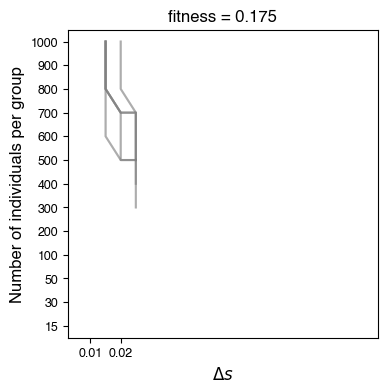

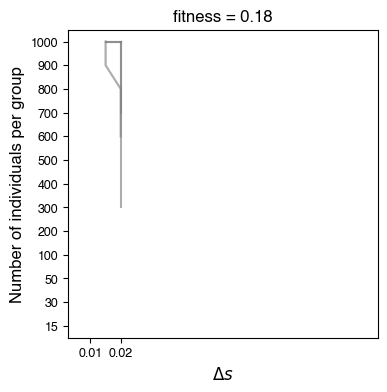

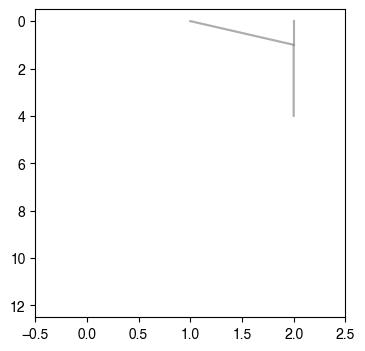

In [604]:

# try to get a plot of this now 
# okay let's try to plot this now accoording to what Jamie was suggesting
# you choose a specific s (say 0.1 for now)
# you want to plot the values for all other s (delta s is the difference)
# you want to then do this for different n 

# we want to go a bit less rough because it is noisy so just 0.1, 0.105, 0.11, 0.115 etc
s_values = np.arange(0.1, 0.201, 0.005).tolist()
s_values = [round(s, 4) for s in s_values]

n_values = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 30, 15] # nr of individuals to sample from each group 
n_labels = [900, 800, 700, 600, 500, 400, 300, 200, 100] # labels to include on the plot 
nx = len(n_values)

fisher_values = {} # I also want to save the results as a csv so will write them to a dictionary

for s in s_values:
    
    # get delta s (difference b/n fitness coefficients)
    deltas = [sv - s for sv in s_values if s < sv]
    deltas = [round(d, 4) for d in deltas]

    fisher_values[s] = {} # empty dictionary
    
    fisher_lists = []
    fisher_thresh = []
    
    for a in range(5):

        seed = a
        random.seed(seed)

        for n in n_values:

            fisher_values[s][n] = {}
            fisher_list = []
            
            for d in deltas:

                # set seed
            
                # get values for different ns for the delta s 
                f1 = s # first s 
                f2 = round(s+d, 4) # second s (can do + or - doesn't matter)
                
                # extract dataframes with the same mu and different fitness values 
                # here I am only compared people "diagnosed with CH" - 2 reads     
                df1 = pd.DataFrame(variants_dict_filt[f1])
                df2 = pd.DataFrame(variants_dict_filt[f2])
                df1['s'] = f1
                df2['s'] = f2

                # merge datasets 
                df = pd.concat([df1, df2])

                # get CH positive cases
                df_chpos = df[df.var_reads2 >= 2].reset_index(drop=True)
                
                # sample n CH-positive individuals  
                df_sub = df_chpos.sample(n = n)

                # get CH positive cases in sampled 
                # nr of CH-positive from different s (those with >= 2 reads)
                df_sub_s1 = df_sub[df_sub.s == f1].reset_index(drop=True)
                df_sub_s2 = df_sub[df_sub.s == f2].reset_index(drop=True)
                
                n1 = df_sub_s1.shape[0]
                n2 = df_sub_s2.shape[0]
                
                # total nr of individuals screened - I am not sure this is fine?
                # NOTE you should ask about this!
                total = 424089 
                
                # nr of CH-negative from different s 
                c1 = total - n1
                c2 = total - n2

                table = [[n1, c1], [n2, c2]]
                stat, pval = fisher_exact(table)  
                pval = round(pval, 4)

                # save these values as a list
                fisher_list.append(pval) 

                # add to the dictionary 
                fisher_values[s][n][d] = pval
        
            fisher_lists.append(fisher_list)
        
        # create a binary matrix 
        fisher_new = [[1 if val < 0.01 else 0 for val in row] for row in fisher_lists]

        # remove noise (highlight inner)   
        fisher2 = []
        
        for i in range(5):
            fisher_sub = fisher_new[i*nx:(i+1)*nx]
            fisher2_sub = modify_list(fisher_sub) # this to be used for plotting (dot plot)
            fisher2.append(fisher2_sub)

        fisher2_flat = [item for sublist in fisher2 for item in sublist]

    # RESULTS 

    # PLOT
    
    boundaries = [0, 0.1, 1]  
    colors = ['white', 'white']  # just white background
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)

    plt.figure(figsize = (4, 4))
    plt.imshow(fisher_new[0:nx], cmap = cmap, aspect = 'auto', norm = norm, interpolation='none')
    
    # plot boundary coordinates
    for i in range(5):
        fisher_bound = fisher2_flat[i*nx : (i+1)*nx]
        boundary_coords = find_boundaries(fisher_bound)
        x_coords = [b[0] for b in boundary_coords]
        y_coords = [b[1] for b in boundary_coords]
        plt.plot(x_coords, y_coords, color = 'grey', linestyle = '-', alpha = 0.4)
        plt.plot(x_coords, y_coords, color = 'grey', linestyle = '-', alpha = 0.4)

    # plot formatting     
    plt.yticks(ticks=np.arange(nx), labels=[n_values[i] for i in range(nx)], fontsize = yticks_font)
    x_ticks = np.arange(1, len(deltas), 2)
    x_labels = [deltas[i] for i in x_ticks]
    plt.xticks(ticks=x_ticks, labels=x_labels, fontsize = xticks_font)
    plt.ylabel('Number of individuals per group', fontsize = yaxis_font)
    plt.xlabel(r'$\Delta s$', fontsize = xaxis_font)
    plt.xlim(-0.5, 20)
    plt.title(label = f'fitness = {s}')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_figures/plot_fisher_sn_s{s}.pdf', bbox_inches='tight')

    # TABLE WITH TEST VALUES 

    # save the fisher values table to csv
    fisher_table = pd.DataFrame(fisher_values[s]) # that is actually the format that worfisher anyway 
    fisher_table.to_csv(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_stat_tables/fisher_test_s{s}_5e7.csv')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know

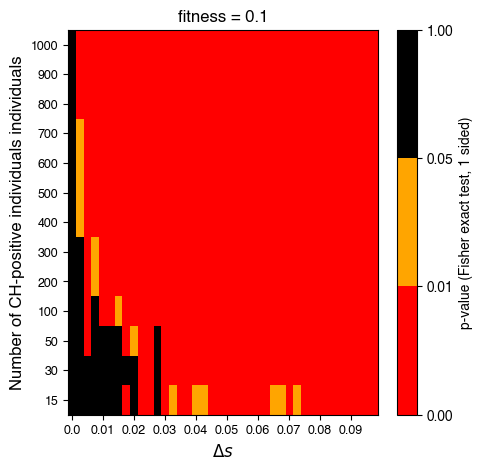

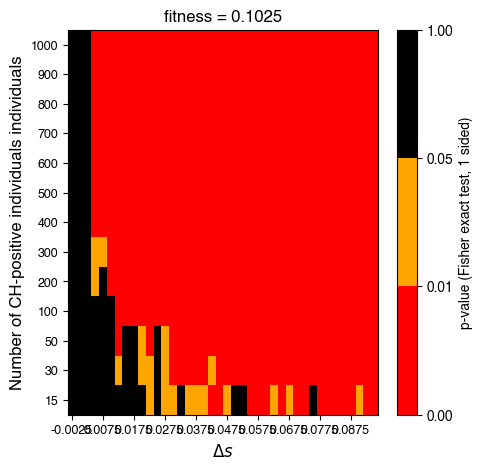

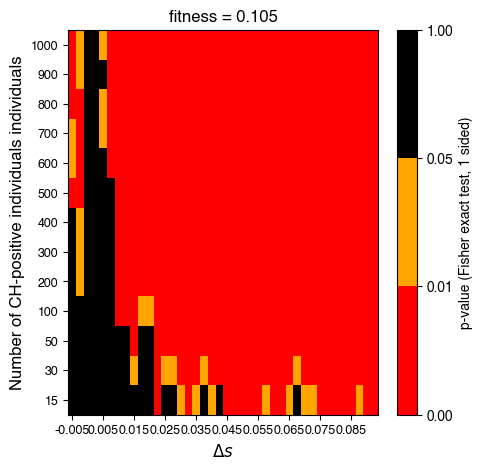

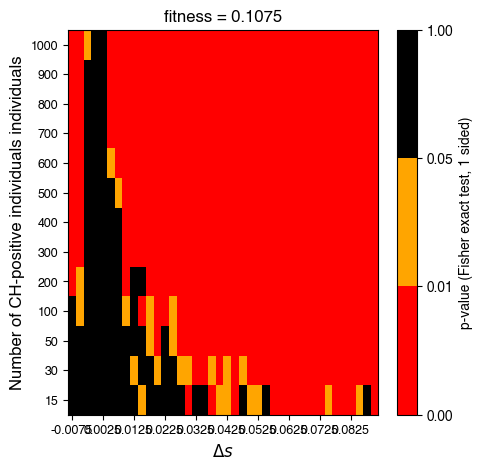

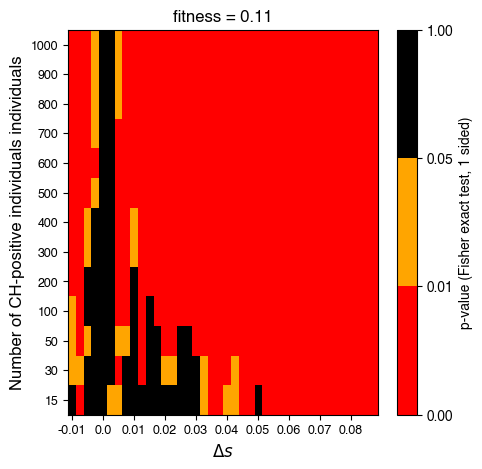

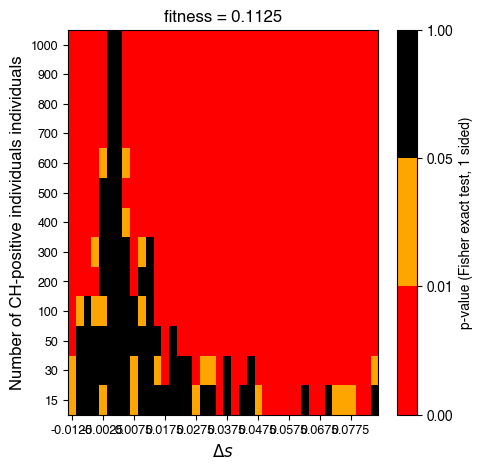

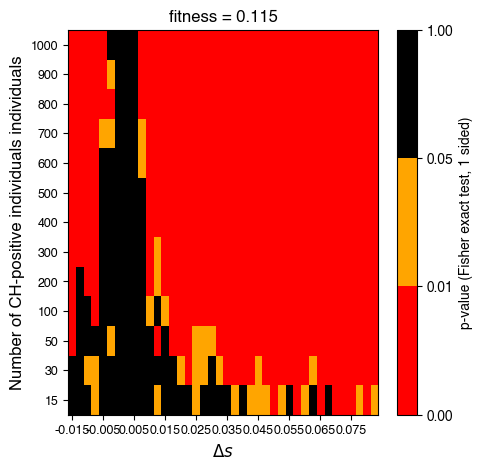

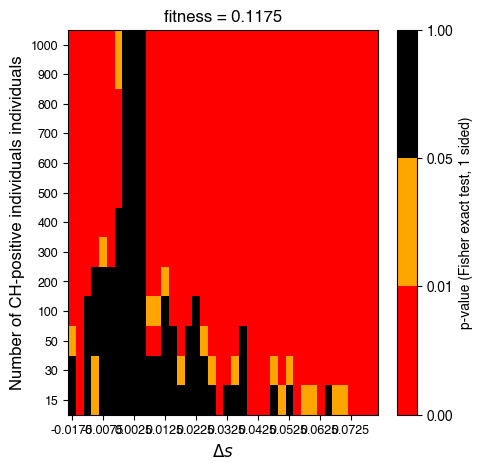

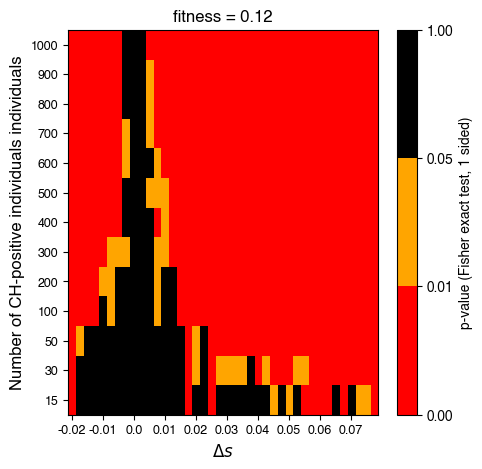

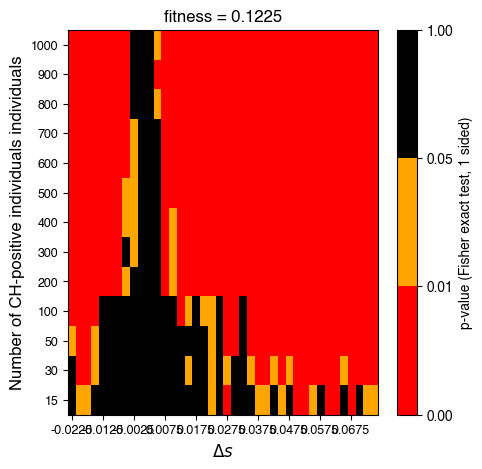

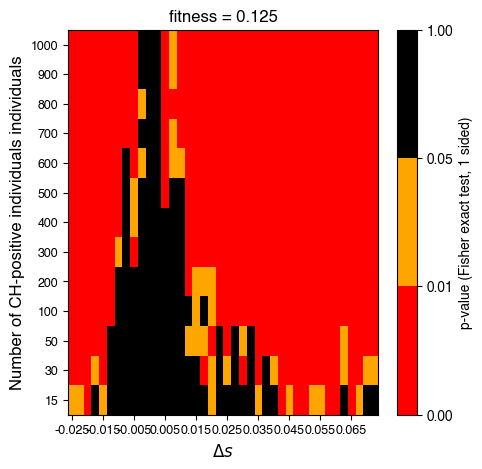

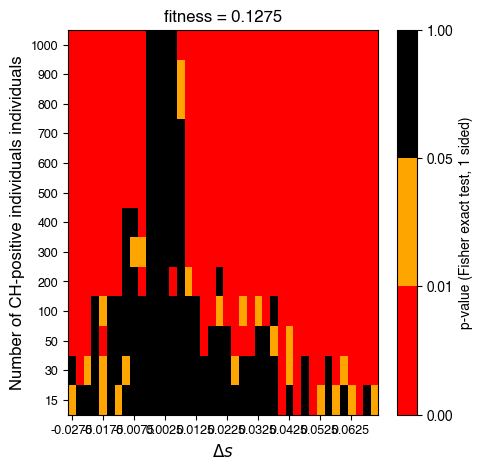

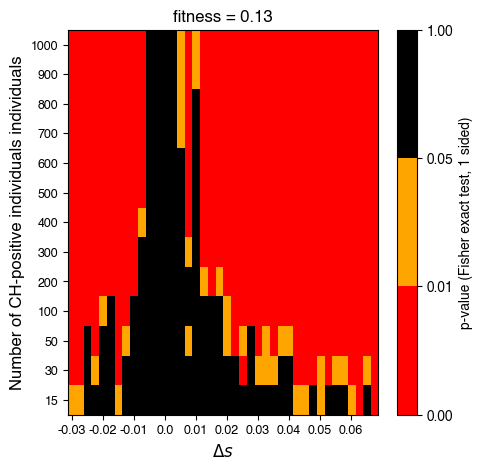

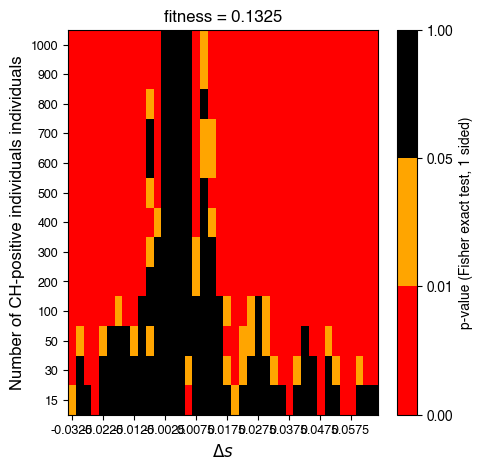

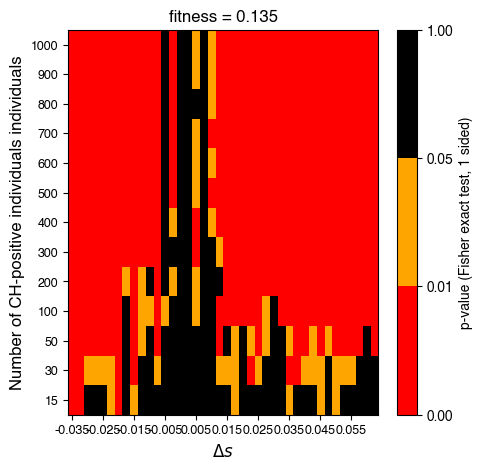

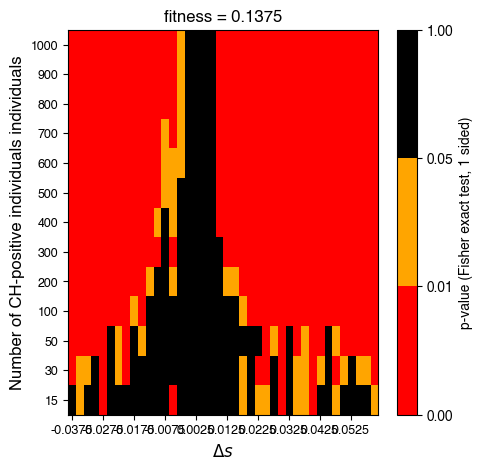

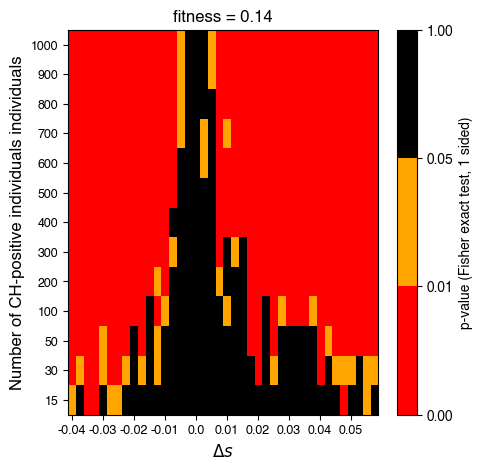

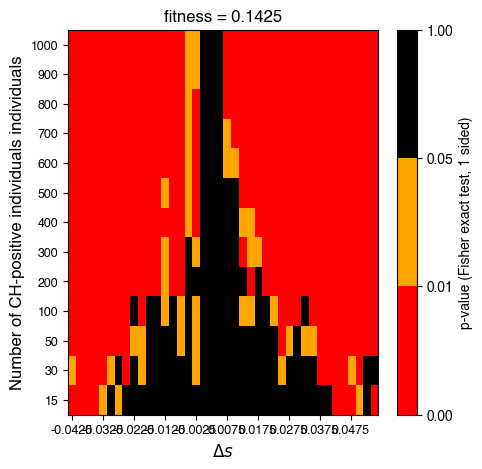

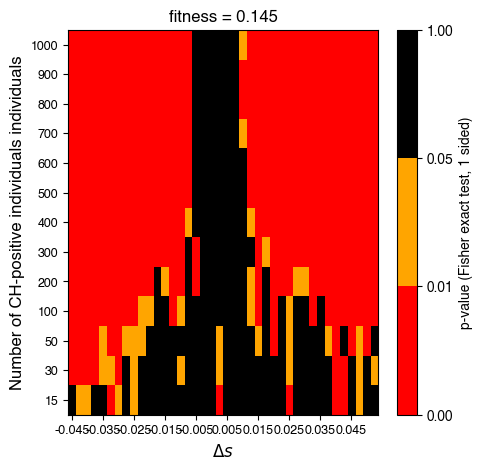

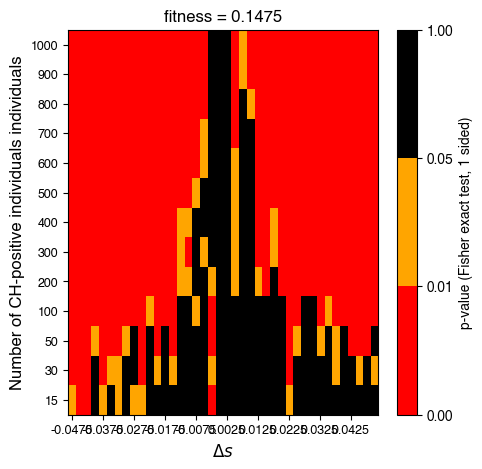

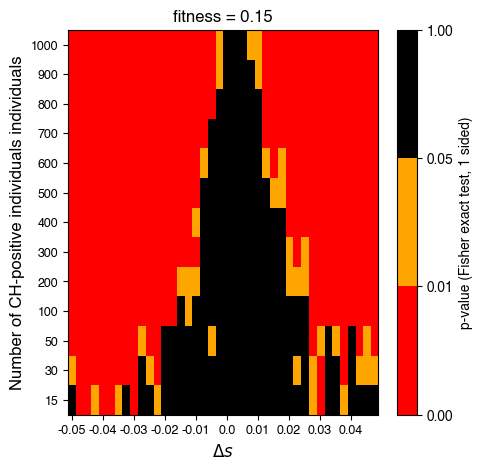

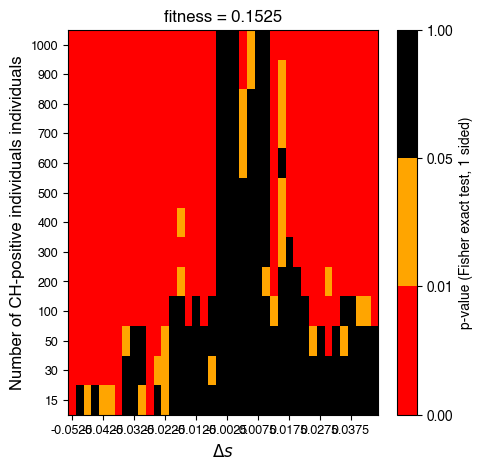

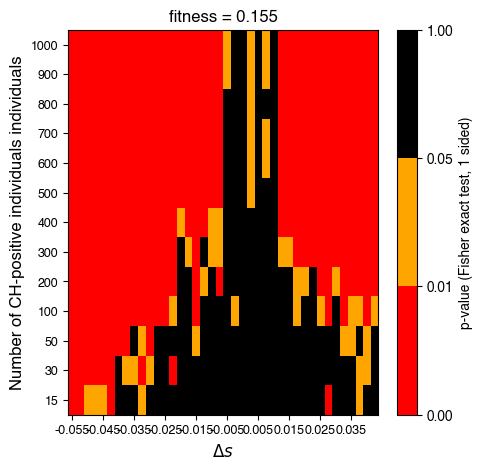

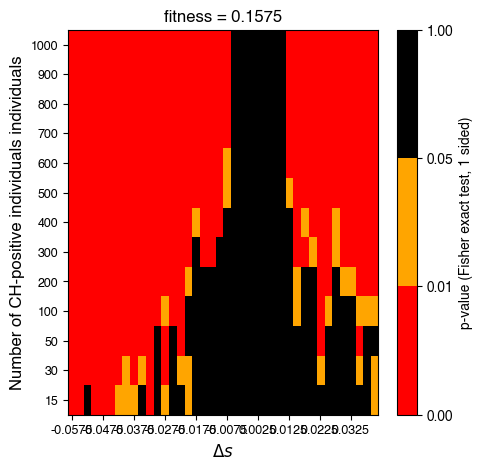

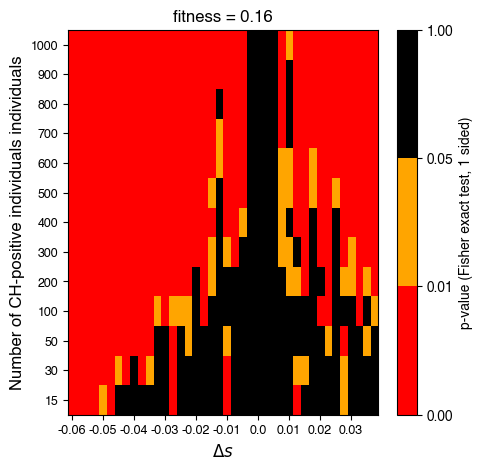

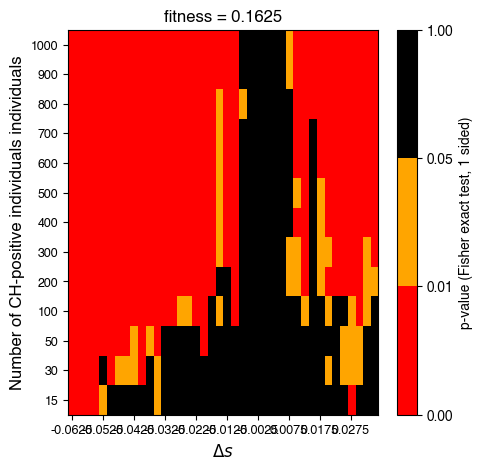

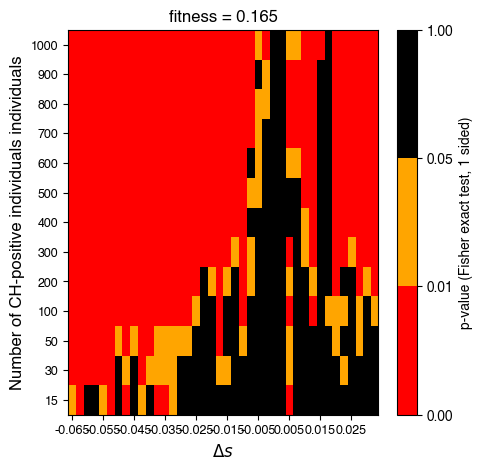

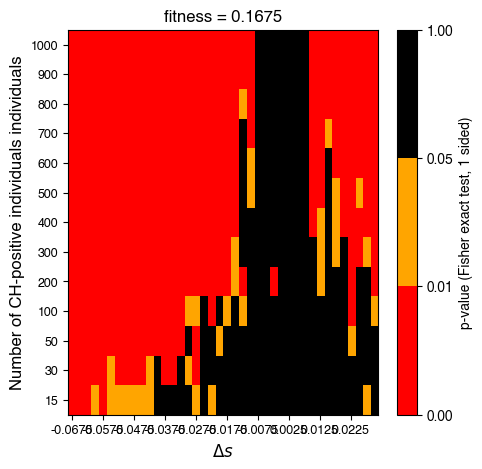

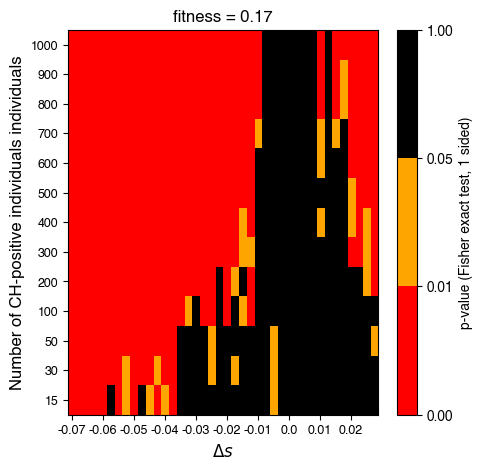

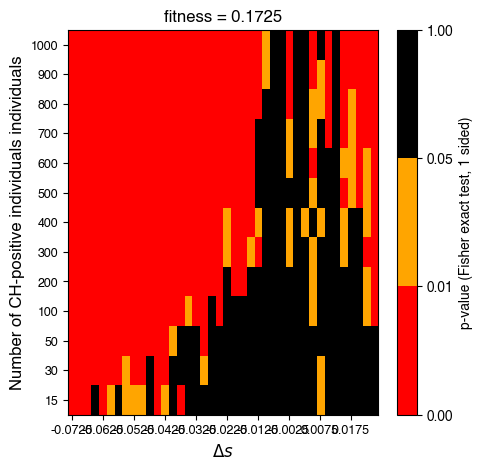

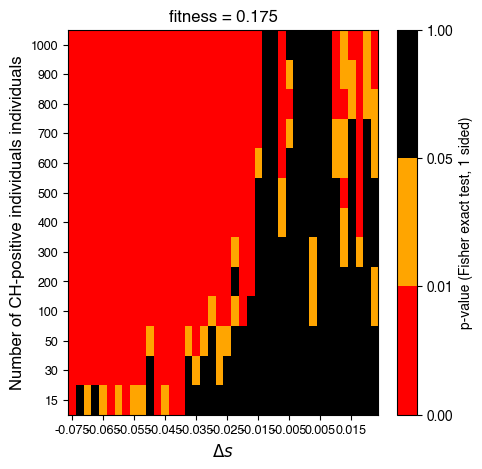

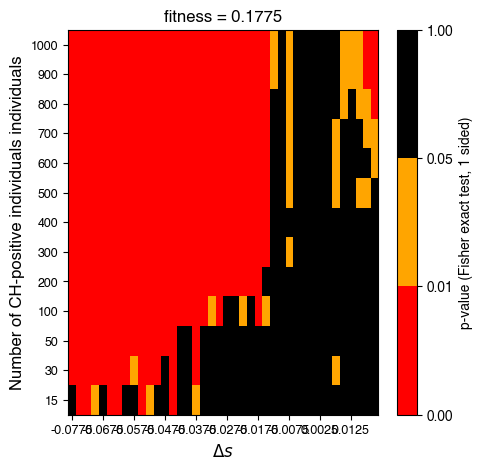

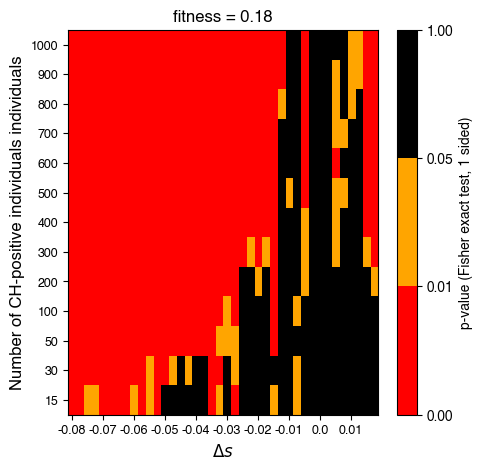

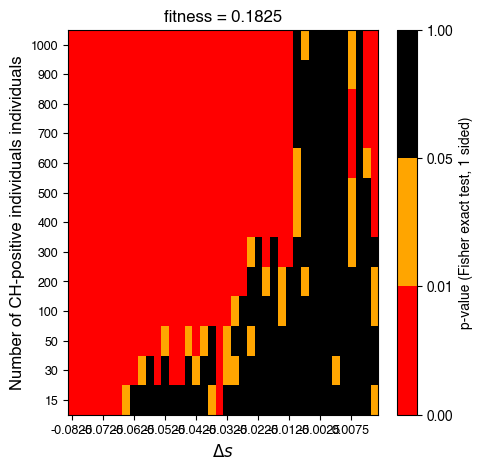

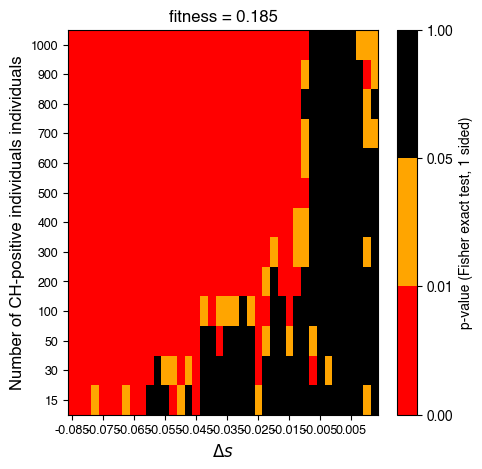

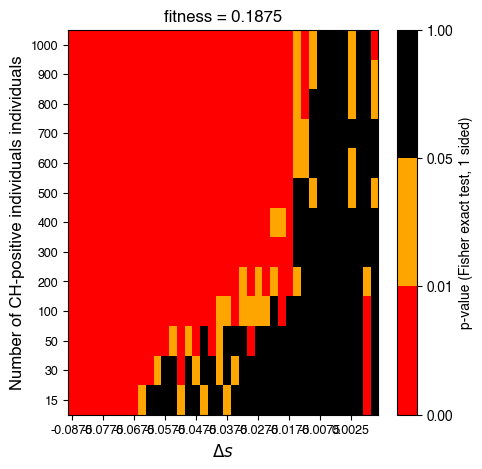

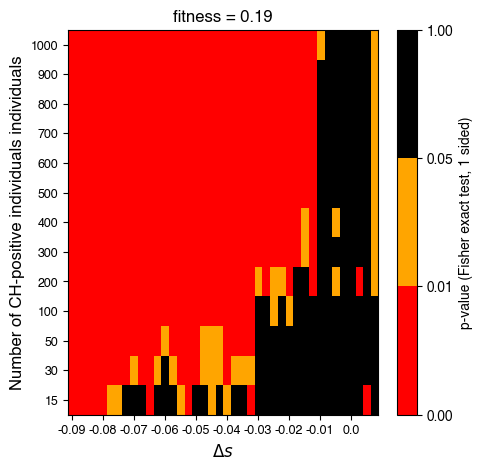

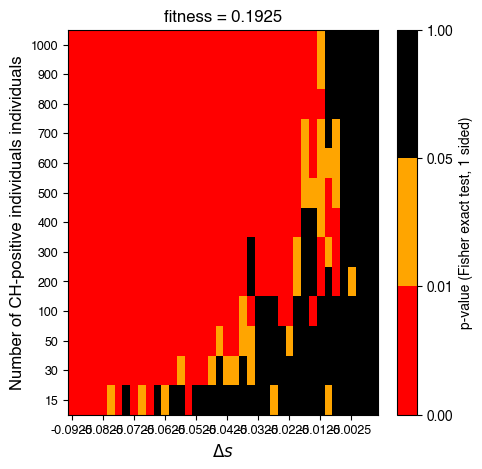

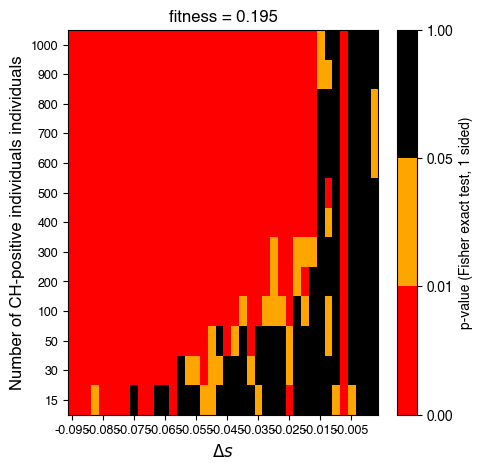

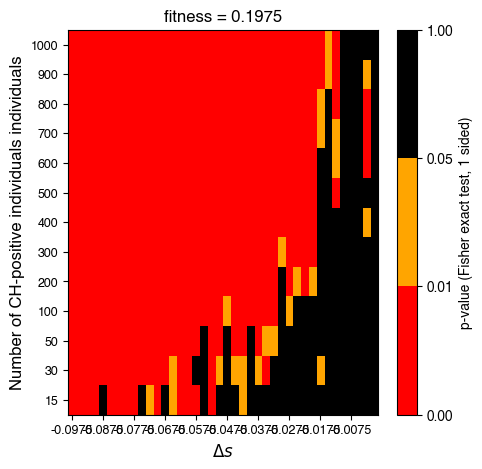

In [175]:
# previous plot version (heatmap)

s_values = np.arange(0.1, 0.2, 0.0025).tolist()
s_values = [round(s, 4) for s in s_values]

n_values = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 30, 15]
n_labels = [900, 800, 700, 600, 500, 400, 300, 200, 100]

fisher_values = {} 

for s in s_values:
    
    # get delta s 
    deltas = [sv - s for sv in s_values]
    deltas = [round(d, 4) for d in deltas]

    fisher_lists = [] 

    fisher_values[s] = {} # empty dictionary 

    for n in n_values:

        fisher_values[s][n] = {}

        fisher_list = []

        for d in deltas:

            # set seed
            seed = 3
            np.random.seed(seed)
            
            # get values for different ns for the delta s 
            f1 = s # first s 
            f2 = round(s+d, 4) # second s (can do + or - doesn't matter)
            
            # extract dataframes with the same mu and different fitness values 
            # here I am only compared people "diagnosed with CH" - 2 reads     
            df1 = pd.DataFrame(variants_dict_filt[f1])
            df2 = pd.DataFrame(variants_dict_filt[f2])
            df1['s'] = f1
            df2['s'] = f2

            # merge datasets 
            df = pd.concat([df1, df2])

            # get CH positive cases
            df_chpos = df[df.var_reads2 >= 2].reset_index(drop=True)
            
            # sample n CH-positive individuals  
            df_sub = df_chpos.sample(n = n)

            # get CH positive cases in sampled 
            # nr of CH-positive from different s (those with >= 2 reads)
            df_sub_s1 = df_sub[df_sub.s == f1].reset_index(drop=True)
            df_sub_s2 = df_sub[df_sub.s == f2].reset_index(drop=True)
            
            n1 = df_sub_s1.shape[0]
            n2 = df_sub_s2.shape[0]
            
            # total nr of individuals screened - I am not sure this is fine?
            # NOTE you should ask about this!
            total = 424089 
            
            # nr of CH-negative from different s 
            c1 = total - n1
            c2 = total - n2

            table = [[n1, c1], [n2, c2]]
            stat, pval = fisher_exact(table)  
            pval = round(pval, 4)

            # save these values as a list
            fisher_list.append(pval) 

            # add to the dictionary 
            fisher_values[s][n][d] = pval
    
        fisher_lists.append(fisher_list)

    # RESULTS 

    # plot 
    boundaries = [0, 0.01, 0.05, 1]  # Thresholds for the color changes
    colors = ['red', 'orange', 'black']  # Colors for each range
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(boundaries, cmap.N)

    plt.figure(figsize = (5, 5))
    plt.imshow(fisher_lists, cmap = cmap, aspect = 'auto', norm = norm, interpolation='none')
    
    plt.yticks(ticks=np.arange(len(fisher_lists)), labels=[n_values[i] for i in range(len(fisher_lists))], fontsize = yticks_font)
    x_ticks = np.arange(0, len(fisher_lists[0]), 4)
    x_labels = [deltas[i] for i in x_ticks]
    plt.xticks(ticks=x_ticks, labels=x_labels, fontsize = xticks_font)
    plt.ylabel('Number of CH-positive individuals individuals', fontsize = yaxis_font)
    plt.xlabel(r'$\Delta s$', fontsize = xaxis_font)
    cbar = plt.colorbar(label='p-value (Fisher exact test, 1 sided)')
    cbar.set_ticks(boundaries)
    plt.title(label = f'fitness = {s}')
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_figures/plot_fisher_sn_s{s}.pdf', bbox_inches='tight')
    # these plots look really blurred / fuzzy if you open in preview but fine if you open with Adobe smhw 

    # TABLE WITH TEST VALUES 
    # save the ks values table to csv
    fisher_table = pd.DataFrame(fisher_values[s]) # that is actually the format that works anyway 
    fisher_table.to_csv(f'/Users/barbarawalkowiak/Desktop/msc_thesis/results/simulation/a_stat_tables/fisher_test_s{s}_5e7.csv')
